In [ ]:
pip install openpyxl

In [ ]:
pip install jieba

In [ ]:
pip install wordcloud

In [ ]:
# 运行代码需要上面的三个包，矩池云中没有

In [2]:
# 导入需要的模块
import tensorflow as tf # tensorflow模块，深度学习框架
import keras # keras模块，深度学习框架
import jieba # jieba，用于分词
import re # 正则表达式
import numpy as np # numpy数组
import pandas as pd # pandas表格
import matplotlib.pyplot as plt # matplotlib 数据可视化
import openpyxl # 读取excel需要的模块
from PIL import Image # 读取图片
from tqdm import tqdm # 显示循环进度条
from sklearn.model_selection import train_test_split # 训练集、验证集、测试集的划分
from itertools import product # 迭代工具
from tensorflow.keras.models import load_model # 用于加载模型
from sklearn.utils import class_weight # 用于计算样本的权重
from sklearn.metrics import roc_curve, auc # 用于绘画ROC曲线，计算AUC值
from keras.preprocessing.image import ImageDataGenerator # keras模块的图片预处理模块，可用于数据增强
from keras.optimizers import Adam # Adam优化器
from collections import Counter # 词频统计包

Using TensorFlow backend.


In [3]:
# 读取存在excel中的动画信息
data = pd.read_excel('../data/动画信息.xlsx',engine='openpyxl')

In [4]:
# 设置随机种子
np.random.seed(233)

# 想要预测的风格
target_style = "科幻"

In [5]:
# 数据预处理：0-1 矩阵
# 提供7个变量：有效前作，主线故事，全为男性，男多于女，女多于男，男女相等
data.index = data["动画ID"]
id_set = set(data["动画ID"])
list1 = ["有效前作","主线故事"]
list2 = ["全为男性","全为女性","男多于女","女多于男","男女相等"]
binary_data = np.zeros((len(data), len(list1) + len(list2)), dtype=np.float32)#初始化0-1矩阵
for i, j in product(range(0, len(data)), range(0, len(list1) + len(list2))):
    if j < len(list1):#前两个变量：有效前作，主线故事
        if np.isnan(data[list1[j]].iloc[i]) == False:
            anime_id = int(data[list1[j]].iloc[i])
            if anime_id in id_set:
                if data.loc[anime_id,target_style] == 1:# 如果有效前作/主线故事的风格与target_style相同
                    binary_data[i,j] = 1
                else:#不同
                    binary_data[i,j] = 0
            else:
                binary_data[i,j] = 0
        else:
            binary_data[i,j] = 0 #无有效前作/主线故事
    else:#后5个变量
        binary_data[i,j] = data[list2[j-2]].iloc[i]

In [6]:
# 数据预处理：动画封面
IMSIZE = 128#统一图片大小为128*128
first_styles, styles = data.columns[4: 14], data.columns[14: 24]
img_file_names = data.loc[:, '动画封面']#图片文件名

imgs = np.zeros([len(img_file_names), IMSIZE, IMSIZE, 3])#初始化
print('Loading images...')
for i, img_file_name in tqdm(enumerate(img_file_names)):#读取图片，存入imgs中
    img = Image.open('../data/动画封面/' + img_file_name)
    img = img.resize([IMSIZE, IMSIZE])
    img = np.array(img, dtype=np.float32) / 255
    imgs[i] = img

5it [00:00, 36.17it/s]

Loading images...


4650it [01:25, 54.37it/s]


In [7]:
# 将对应的标签拿出来
labels = np.array(data.loc[:, target_style], dtype=np.int32)

# 分词处理：动画简介
intro_texts = data.loc[:, '动画简介']
intro_texts = [
    [word for word in jieba.lcut(intro_text)] 
    for intro_text in intro_texts]

# 分词处理：动画名
title_texts = data.loc[:, '动画名']
title_texts = [
    [word for word in jieba.lcut(title_text)]
    for title_text in title_texts]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.837 seconds.
Prefix dict has been built successfully.


In [8]:
# 训练集，验证集，测试集的划分
img_halfway,img_test,\
text_halfway,text_test,\
title_halfway,title_test,\
binary_halfway,binary_test,\
label_halfway,label_test = train_test_split(
    imgs, intro_texts, title_texts, binary_data, labels,
    test_size=0.2, 
    stratify=labels,
    random_state=233) # （大）训练集和测试集的划分

img_train,img_val,\
text_train,text_val,\
title_train,title_val,\
binary_train,binary_val,\
label_train,label_val = train_test_split(
    img_halfway, text_halfway, title_halfway, binary_halfway, label_halfway,
    test_size=0.2, 
    stratify=label_halfway,
    random_state=233)  # 训练集和验证集的划分

print(img_train.shape)
print(text_train[0]) # 此时文本还没有数字化

(2976, 128, 128, 3)
['鬼', '冢', '英吉是', '前', '飞车', '党员', '，', '为了', '想要', '接近', '高中女生', '而', '决定', '参加', '代课', '教师', '的', '面试', '，', '训导主任', '内', '山田', '认为', '他', '不', '适合', '当', '老师', '，', '只是', '想', '接近', '高中女生', '而已', '，', '所以', '不', '打算', '任用', '他', '，', '随后', '又', '有', '两位', '学生', '想要', '找内', '山田', '算', '帐', '，', '内', '山田', '叫', '鬼', '冢', '把', '那', '两位', '人渣', '制伏', '就让', '他', '当', '老师', '，', '但是', '鬼', '冢', '却', '不满', '内', '山田', '对待', '学生', '的', '态度', '，', '于是', '向', '理事长', '讲', '了', '他', '的', '大道理', '，', '理事长', '也', '觉得', '学校', '有', '很多', '问题', '需要', '他', '这种', '人来', '解决', '，', '这样', '阴差阳错', '竟', '让', '他', '梦想成真', '。', '但', '当', '了', '老师', '的', '他', '受到', '学校', '的', '老师', '和', '学生', '排挤', '，', '经常', '差点', '便', '被', '开除', '，', '但', '每次', '他', '都', '能', '化险为夷', '，', '用', '他', '那', '独特', '的', '教学方法', '，', '或', '以暴易暴', '，', '或', '故意', '放任', '，', '总之', '，', '他', '以', '“', '关心', '学生', '，', '万事', '以', '学生', '为', '中心', '”', '出发', '，', '因材施教', '，', '最终', '将', '一帮', '问题', '学生', '收服', '得', '

In [9]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(label_train),label_train) # 计算样本权重

In [10]:
plt.style.use('ggplot') # 使用ggplot风格

def ROC(y_true,y_pre):#用于绘制ROC曲线
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1) #计算真正率和假正率
    roc_auc = auc(fpr,tpr) #计算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc) #绘制ROC曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') #绘制直线y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('ROC curve of Science Fiction',fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

In [11]:
'''
model1 : 数据增强 + 一般CNN
'''
#模型结构
n_channel = 20
inp_img = keras.layers.Input([IMSIZE, IMSIZE, 3])#输入动画封面
x = inp_img
for _ in range(5):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(n_channel, [2, 2], padding='same', activation='relu')(x)
    x = keras.layers.MaxPooling2D([2, 2])(x)
    if i == 4:
        x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x)#预测层：二分类
model1=keras.Model(inputs=inp_img,outputs=preds)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 20)      260       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 20)        80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 20)        1620      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 20)        0   

In [12]:
datagen = ImageDataGenerator(#数据增强
    shear_range=0.5, # 表示拉伸变换
    zoom_range=0.2,  # 用于定义图像放大或者缩小的比例
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(img_train)

In [13]:
model1.compile(optimizer = Adam(0.001),loss = 'binary_crossentropy',metrics = ['accuracy']) #损失函数是交叉熵，评价指标是准确率
early1_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min',restore_best_weights=True) # 采用早停的策略
model1.fit_generator(
    datagen.flow(img_train, label_train, batch_size=64),
    validation_data=[img_val, label_val],
    epochs=100,
    callbacks=[early1_stopping],
    shuffle=True,class_weight=class_weights) # 样本被加了权重

Epoch 1/100
47/47 [==============================] - 12s 256ms/step - loss: 0.5719 - accuracy: 0.7319 - val_loss: 0.6144 - val_accuracy: 0.7608
Epoch 2/100
47/47 [==============================] - 10s 216ms/step - loss: 0.5341 - accuracy: 0.7436 - val_loss: 0.5755 - val_accuracy: 0.7608
Epoch 3/100
47/47 [==============================] - 11s 228ms/step - loss: 0.5219 - accuracy: 0.7530 - val_loss: 0.5574 - val_accuracy: 0.7608
Epoch 4/100
47/47 [==============================] - 11s 225ms/step - loss: 0.5210 - accuracy: 0.7550 - val_loss: 0.5553 - val_accuracy: 0.7594
Epoch 5/100
47/47 [==============================] - 11s 235ms/step - loss: 0.5065 - accuracy: 0.7571 - val_loss: 0.5060 - val_accuracy: 0.7608
Epoch 6/100
47/47 [==============================] - 10s 218ms/step - loss: 0.5118 - accuracy: 0.7530 - val_loss: 0.5249 - val_accuracy: 0.7608
Epoch 7/100
47/47 [==============================] - 11s 226ms/step - loss: 0.5007 - accuracy: 0.7577 - val_loss: 0.5456 - val_accuracy:

<Figure size 432x288 with 0 Axes>

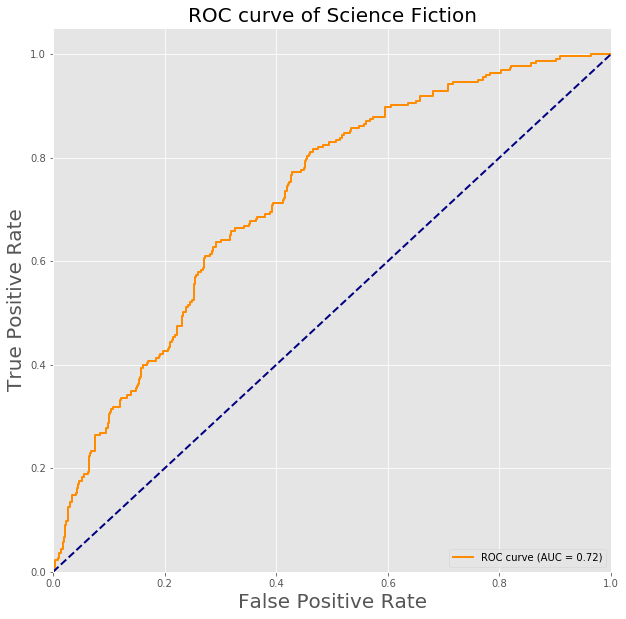

In [14]:
#对测试集做预测，并绘制ROC曲线
predict_test = model1.predict(img_test)
ROC(list(label_test.flatten()),predict_test.flatten())

In [15]:
# 记录训练集、验证集、测试集的预测层的结果（取值范围为0~1）
train_result1 = model1.predict(img_train)
val_result1 = model1.predict(img_val)
test_result1 = model1.predict(img_test)

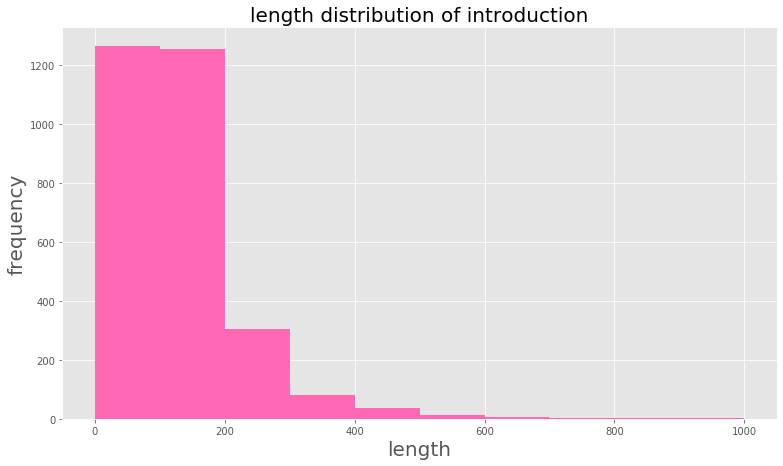

In [16]:
intro_lengths = [len(introduction) for introduction in text_train]#统计简介的长度

#绘制简介长度的直方图
fig,axe = plt.subplots(figsize=(12.8,7.2))
axe.hist(intro_lengths,bins=[0,100,200,300,400,500,600,700,800,900,1000],color="hotpink")
axe.set_title("length distribution of introduction",fontsize=20)
axe.set_xlabel("length",fontsize=20)
axe.set_ylabel("frequency",fontsize=20)
plt.show()

SENLEN = 400

# VOCAB_SIZE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in text_train for word in sequence]
word_counter_introduction = Counter(train_word_list)#统计每个词出现的次数
most_common_word_in_train_introduction = word_counter_introduction.most_common()#词频降序排序
VOCAB_SIZE = len(most_common_word_in_train_introduction) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_introduction)):
    if most_common_word_in_train_introduction[i][1] <= 1:
        VOCAB_SIZE = i + 1 #VOCAB_SIZE设为词频>=2的词的数量
        break
        
# 对训练集建表
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(text_train)

# 将训练集的文本数字化
text_train = tokenizer.texts_to_sequences(text_train)
text_train = keras.preprocessing.sequence.pad_sequences(
    text_train, maxlen=SENLEN, padding='post')

# 将验证集的文本数字化
text_val = tokenizer.texts_to_sequences(text_val)
text_val = keras.preprocessing.sequence.pad_sequences(
    text_val, maxlen=SENLEN, padding='post')

# 将测试集的文本数字化
text_test = tokenizer.texts_to_sequences(text_test)
text_test = keras.preprocessing.sequence.pad_sequences(
    text_test, maxlen=SENLEN, padding='post')

In [17]:
'''

model2 : 对于简介，Bi-LSTM

'''

EMBED_SIZE = 128

# Bi-LSTM
inp_text = keras.layers.Input(shape=(SENLEN,)) #输入简介，长度为SENLEN
embed = keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=SENLEN,mask_zero=True)(inp_text) #词嵌入层
x = keras.layers.Bidirectional(keras.layers.LSTM(EMBED_SIZE))(embed)# Bi-LSTM
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model2=keras.Model(inputs=inp_text,outputs=preds)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 128)          2375552   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3289

In [18]:
model2.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ["accuracy"]) #损失函数是交叉熵，评价指标是准确率
early2_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, mode='min',restore_best_weights=True) # 采用早停的策略
model2.fit(text_train, label_train,
    validation_data=[text_val,label_val],
    epochs=100,
    batch_size=64,
    callbacks=[early2_stopping],
    shuffle=True,class_weight=class_weights)

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2976 samples, validate on 744 samples
Epoch 1/100
2976/2976 [==============================] - 45s 15ms/step - loss: 0.6807 - accuracy: 0.6848 - val_loss: 0.6548 - val_accuracy: 0.7608
Epoch 2/100
2976/2976 [==============================] - 44s 15ms/step - loss: 0.5936 - accuracy: 0.7604 - val_loss: 0.5617 - val_accuracy: 0.7608
Epoch 3/100
2976/2976 [==============================] - 44s 15ms/step - loss: 0.5477 - accuracy: 0.7604 - val_loss: 0.5451 - val_accuracy: 0.7608
Epoch 4/100
2976/2976 [==============================] - 44s 15ms/step - loss: 0.5277 - accuracy: 0.7604 - val_loss: 0.5256 - val_accuracy: 0.7608
Epoch 5/100
2976/2976 [==============================] - 44s 15ms/step - loss: 0.4670 - accuracy: 0.7604 - val_loss: 0.4629 - val_accuracy: 0.7608
Epoch 6/100
2976/2976 [==============================] - 44s 15ms/step - loss: 0.3444 - accuracy: 0.8001 - val_loss: 0.4373 - val_accuracy: 0.8710
Epoch 7/100
2976/2976 [==============================] - 44s 15ms/step 

<Figure size 432x288 with 0 Axes>

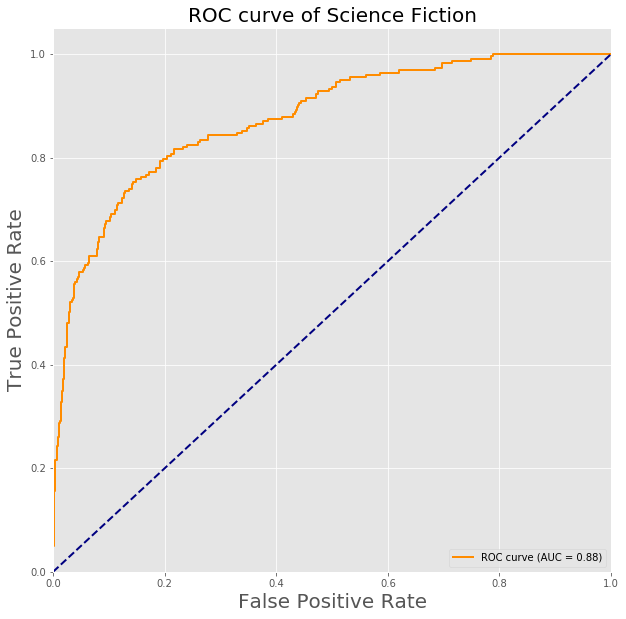

In [19]:
#对测试集做预测，并绘制ROC曲线
predict_test = model2.predict(text_test)
ROC(list(label_test.flatten()),predict_test.flatten())

In [20]:
# 记录训练集、验证集、测试集的预测层的结果（取值范围为0~1）
train_result2 = model2.predict(text_train)
val_result2 = model2.predict(text_val)
test_result2 = model2.predict(text_test)

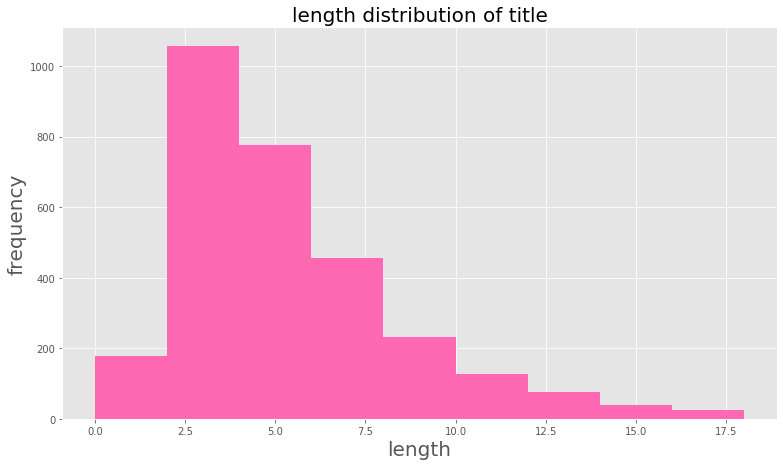

In [21]:
title_lengths = [len(title) for title in title_train] #统计动画名的长度
#绘制动画名长度的直方图
plt.style.use('ggplot')
fig,axe = plt.subplots(figsize=(12.8,7.2))
axe.hist(title_lengths,bins=[0,2,4,6,8,10,12,14,16,18],color="hotpink")
axe.set_title("length distribution of title",fontsize=20)
axe.set_xlabel("length",fontsize=20)
axe.set_ylabel("frequency",fontsize=20)
plt.show()

# 数据预处理：动画名
SENLEN_TITLE = 16

# VOCAB_SIZE_TITLE 的决定:训练集上该词出现的次数>=2
train_word_list = [word for sequence in title_train for word in sequence]
word_counter_title = Counter(train_word_list)
most_common_word_in_train_title = word_counter_title.most_common()
VOCAB_SIZE_TITLE = len(most_common_word_in_train_title) + 1 # 设置一个初值，大概率结果不是这个
for i in range(len(most_common_word_in_train_title)):
    if most_common_word_in_train_title[i][1] <= 1:
        VOCAB_SIZE_TITLE = i + 1
        break
        
# 对训练集建表
tokenizer_title = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE_TITLE)
tokenizer_title.fit_on_texts(title_train)

# 将训练集的文本数字化
title_train = tokenizer_title.texts_to_sequences(title_train)
title_train = keras.preprocessing.sequence.pad_sequences(
    title_train, maxlen=SENLEN_TITLE, padding='post')

# 将验证集的文本数字化
title_val = tokenizer_title.texts_to_sequences(title_val)
title_val = keras.preprocessing.sequence.pad_sequences(
    title_val, maxlen=SENLEN_TITLE, padding='post')

# 将测试集的文本数字化
title_test = tokenizer_title.texts_to_sequences(title_test)
title_test = keras.preprocessing.sequence.pad_sequences(
    title_test, maxlen=SENLEN_TITLE, padding='post')

In [22]:
'''

model3: 对于标题，text-cnn

'''

EMBED_SIZE_TITLE = 128

# text-cnn
inp_text_title = keras.layers.Input(shape=(SENLEN_TITLE,)) #输入动画名，长度为SENLEN_TITLE
embed = keras.layers.Embedding(VOCAB_SIZE_TITLE, EMBED_SIZE_TITLE, input_length=SENLEN_TITLE,mask_zero=False)(inp_text_title)
cnn1 = keras.layers.Conv1D(128,1,padding='same', strides=1, activation='relu')(embed)
cnn1 = keras.layers.MaxPooling1D(pool_size=SENLEN_TITLE)(cnn1)
cnn2 = keras.layers.Conv1D(128,2,padding='same', strides=1, activation='relu')(embed)
cnn2 = keras.layers.MaxPooling1D(pool_size=SENLEN_TITLE)(cnn2)
cnn3 = keras.layers.Conv1D(128,3,padding='same', strides=1, activation='relu')(embed)
cnn3 = keras.layers.MaxPooling1D(pool_size=SENLEN_TITLE)(cnn3)
x = keras.layers.concatenate([cnn1, cnn2, cnn3], axis=-1)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
preds=keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model3=keras.Model(inputs=inp_text_title,outputs=preds)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 16, 128)      215296      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 16, 128)      16512       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16, 128)      32896       embedding_2[0][0]                
____________________________________________________________________________________________

In [23]:
model3.compile(optimizer = Adam(1e-4),loss = 'binary_crossentropy',metrics = ['accuracy']) #损失函数是交叉熵，评价指标是准确率
early3_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='min',restore_best_weights=True) # 采用早停的策略
model3.fit(title_train, label_train,
    validation_data=[title_val,label_val],
    epochs=100,
    batch_size=64,
    callbacks=[early3_stopping],
    shuffle=True,class_weight=class_weights)

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2976 samples, validate on 744 samples
Epoch 1/100
2976/2976 [==============================] - 1s 425us/step - loss: 0.6300 - accuracy: 0.7356 - val_loss: 0.5669 - val_accuracy: 0.7608
Epoch 2/100
2976/2976 [==============================] - 1s 200us/step - loss: 0.5521 - accuracy: 0.7604 - val_loss: 0.5494 - val_accuracy: 0.7608
Epoch 3/100
2976/2976 [==============================] - 1s 201us/step - loss: 0.5474 - accuracy: 0.7604 - val_loss: 0.5442 - val_accuracy: 0.7608
Epoch 4/100
2976/2976 [==============================] - 1s 207us/step - loss: 0.5435 - accuracy: 0.7604 - val_loss: 0.5382 - val_accuracy: 0.7608
Epoch 5/100
2976/2976 [==============================] - 1s 201us/step - loss: 0.5331 - accuracy: 0.7604 - val_loss: 0.5288 - val_accuracy: 0.7608
Epoch 6/100
2976/2976 [==============================] - 1s 203us/step - loss: 0.5167 - accuracy: 0.7604 - val_loss: 0.5130 - val_accuracy: 0.7608
Epoch 7/100
2976/2976 [==============================] - 1s 216us/step 

<Figure size 432x288 with 0 Axes>

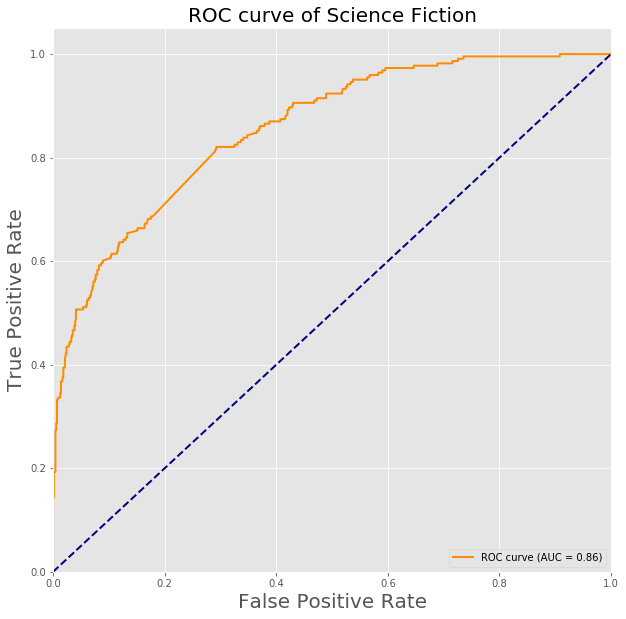

In [24]:
#对测试集做预测，并绘制ROC曲线
predict_test = model3.predict(title_test)
ROC(list(label_test.flatten()),predict_test.flatten())

In [25]:
# 记录训练集、验证集、测试集的预测层的结果（取值范围为0~1）
train_result3 = model3.predict(title_train)
val_result3 = model3.predict(title_val)
test_result3 = model3.predict(title_test)

In [26]:
'''

model4: 仅采用0-1变量

'''

inp_binary = keras.layers.Input(shape=(len(list1)+len(list2),))#输入0-1变量
x = keras.layers.Dense(len(list1)+len(list2),activation='tanh')(inp_binary)
preds = keras.layers.Dense(1,activation='sigmoid')(x) #预测层：二分类
model4 = keras.Model(inputs=inp_binary,outputs=preds)
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [27]:
model4.compile(optimizer = Adam(3e-4),loss = 'binary_crossentropy',metrics = ['accuracy']) #损失函数是交叉熵，评价指标是准确率
early4_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, mode='min',restore_best_weights=True) # 采用早停的策略
model4.fit(binary_train, label_train,
    validation_data=[binary_val,label_val],
    epochs=200,
    batch_size=64,
    callbacks=[early4_stopping],
    shuffle=True,verbose=0,class_weight=class_weights)

<Figure size 432x288 with 0 Axes>

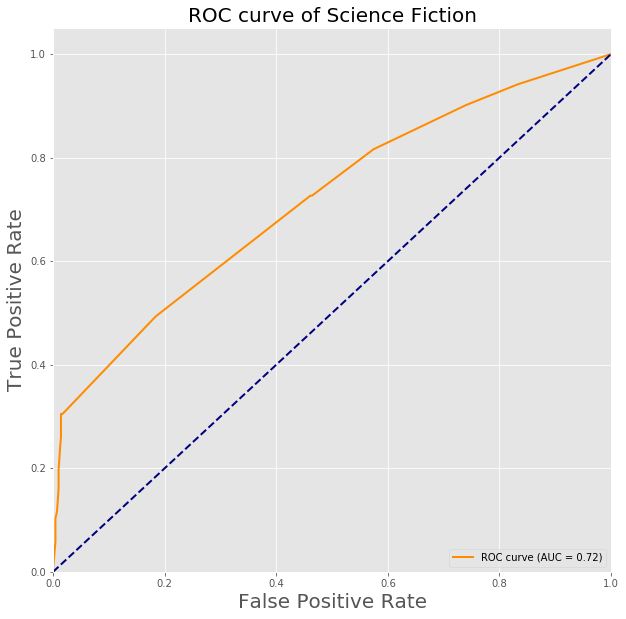

In [28]:
#对测试集做预测，并绘制ROC曲线
predict_test = model4.predict(binary_test)
ROC(list(label_test.flatten()),predict_test.flatten())

In [29]:
# 记录训练集、验证集、测试集的预测层的结果（取值范围为0~1）
train_result4 = model4.predict(binary_train)
val_result4 = model4.predict(binary_val)
test_result4 = model4.predict(binary_test)

In [30]:
'''
model5:投票模型
'''
inp_final = keras.layers.Input(shape=(4,)) #输入model1-model4的输出结果
x = inp_final
x = keras.layers.Dense(4,activation='tanh')(x)
preds = keras.layers.Dense(1,activation='sigmoid')(x)
model5 = keras.Model(inputs=inp_final,outputs=preds) #预测层：二分类
model5.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [31]:
def f(x): # 取sigmoid函数的反函数，然后再标准化
    x = -np.log( 1/x - 1)
    x = (x - np.mean(x)) / np.std(x)
    return x

In [32]:
#将model1-model4的输出结果还原为sigmoid之前的值，并做合并
train_final = np.concatenate((f(train_result1),f(train_result2),f(train_result3),f(train_result4)),axis=1)
val_final = np.concatenate((f(val_result1),f(val_result2),f(val_result3),f(val_result4)),axis=1)
test_final = np.concatenate((f(test_result1),f(test_result2),f(test_result3),f(test_result4)),axis=1)

model5.compile(optimizer = Adam(3e-4),loss = 'binary_crossentropy',metrics = ['accuracy']) #损失函数是交叉熵，评价指标是准确率
early5_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, mode='min',restore_best_weights=True) # 采用早停的策略
model5.fit(train_final, label_train,
    validation_data=[val_final,label_val],
    epochs=200,
    batch_size=64,
    callbacks=[early5_stopping],
    shuffle=True,verbose=0,class_weight=class_weights)

<Figure size 432x288 with 0 Axes>

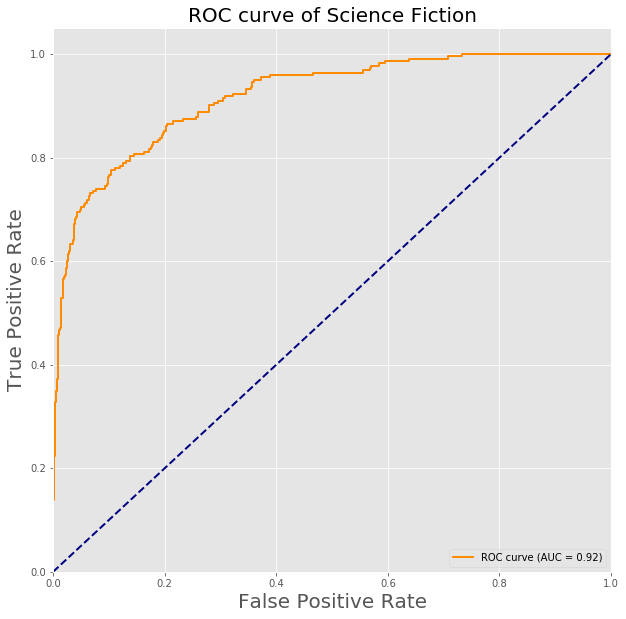

In [33]:
#对测试集做预测，并绘制ROC曲线
predict_test = model5.predict(test_final)
ROC(list(label_test.flatten()),predict_test.flatten())